In [3]:
from dna_db import read_db, get_engine
import pandas as pd

In [12]:
df_raw = None
for i in range(0,8):
    week_id = 202041 + i
    engine = get_engine('dna_prod')
    query = """
            select yearweek, geohash7, longitude, latitude, signalstrength 
            from tutela.tutela_grid_qq_{}
            where region = 'CENTRAL JABOTABEK' 
                and operator = 'Telkomsel'
                and node ='4G'""".format(week_id)
    df_temp = pd.read_sql(sql=query, con=engine)
    if i > 0:
        df_raw = pd.concat([df_raw, df_temp])
    else :
        df_raw = df_temp
df_raw.to_csv('temp_jakpus.csv')
    

In [12]:
df_raw.to_csv('temp_jakpus.csv')

In [1]:
from pyspark.sql.window import *
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as sf 
from pyspark import SparkConf
import os
import datetime
from datetime import date, timedelta
import time
import uuid

PG = {
    'url' : 'jdbc:postgresql://10.53.205.5:5432/ams_lk_001',
    'properties': {
        'user': 'postgres',
        'password': 'Immsp4102',
        'driver': 'org.postgresql.Driver',
        "stringtype":"unspecified"},
    'psy_prop': 'dbname=ams_lk_001 user=postgres host=10.53.205.5 port=5432 password=Immsp4102'
}
def get_spark_session_gh(app_name):

    postgresjar_fn = '/lib/postgresql-42.2.8.jar'
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-class-path ' + postgresjar_fn + ' --jars ' + postgresjar_fn +' pyspark-shell'

    #note if running in server
    os.environ['PYSPARK_PYTHON'] = "/usr/local/bin/python3.7"
    os.environ['PYSPARK_DRIVER_PYTHON'] = "/usr/local/bin/python3.7"
    os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.212.b04-0.el7_6.x86_64"
    os.environ['SPARK_HOME'] = "/opt/spark"
    os.environ['PYTHONPATH'] = "$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip"
    print(os.environ.get('PYTHONPATH'))
    conf_local = SparkConf()
    conf_local.set("spark.driver.host", "localhost")
    conf_local.setMaster("local[*]")
    conf_local.set("spark.cores.max", 42) #jumlah core
    conf_local.setAppName(app_name)
    conf_local.set('spark.executor.memory', '50G')
    conf_local.set('spark.driver.memory', '50G')
    conf_local.set('spark.driver.maxResultSize', '50G')
    conf_local.set("spark.default.parallelism", 8) #paralleism untuk join misalnya
    conf_local.set("spark.sql.shuffle.partitions", 8)
    conf_local.set("spark.executor.heartbeatInterval", 35000)
    conf_local.set("spark.network.timeout", '10h')
    spark = SparkSession.builder.config(conf=conf_local).getOrCreate()

    return spark

def pg_read(spark, query):
    # print(query)
    query = """(""" + query + """) as t"""
    df = spark.read.jdbc(properties=PG['properties'], url=PG['url'], table=query)
    return df

def pg_write(df, table, mode):
    df.write.jdbc(properties=PG['properties'], url=PG['url'], table=table, mode=mode)

In [2]:
spark = get_spark_session_gh('temp_ravi_4')
sc = spark.sparkContext
# sc.setCheckpointDir("/tmp/drv/")
sc.setLogLevel("ERROR")

$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip


In [27]:
df_raw = spark.read.csv('temp_jakpus.csv',header=True, inferSchema=True)

In [32]:
df_raw.schema

StructType(List(StructField(_c0,IntegerType,true),StructField(yearweek,IntegerType,true),StructField(geohash7,StringType,true),StructField(longitude,DoubleType,true),StructField(latitude,DoubleType,true),StructField(signalstrength,DoubleType,true)))

In [15]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count
window_gh = Window.partitionBy('geohash7')
df_raw.withColumn('geohash7_cnt', count('geohash7').over(window_gh)).show()

+-----+--------+--------+------------------+-------------------+--------------+------------+
|  _c0|yearweek|geohash7|         longitude|           latitude|signalstrength|geohash7_cnt|
+-----+--------+--------+------------------+-------------------+--------------+------------+
|24810|  202041| qqggy1q|106.79603576660158|-6.3645172119140625|         -90.0|          16|
|46208|  202041| qqggy1q|106.79603576660158|-6.3645172119140625|         -90.0|          16|
|25807|  202042| qqggy1q|106.79603576660158|-6.3645172119140625|         -91.0|          16|
|33754|  202042| qqggy1q|106.79603576660158|-6.3645172119140625|         -91.0|          16|
| 1410|  202043| qqggy1q|106.79603576660158|-6.3645172119140625|         -91.0|          16|
|47030|  202043| qqggy1q|106.79603576660158|-6.3645172119140625|         -91.0|          16|
|23502|  202044| qqggy1q|106.79603576660158|-6.3645172119140625|         -91.0|          16|
|34247|  202044| qqggy1q|106.79603576660158|-6.3645172119140625|      

In [48]:
df_new = df_raw.groupBy('yearweek', 'geohash7').agg(sf.max(sf.col('signalstrength')).alias('signalstrength')).withColumn('geohash7_cnt', count('geohash7').over(window_gh)).filter(sf.col('geohash7_cnt') == 8).select('yearweek', 'geohash7', 'signalstrength').toPandas()

In [49]:
df_new.to_csv('temp_jakpus_2.csv')

In [50]:
df_new.count()

yearweek          226592
geohash7          226592
signalstrength    226260
dtype: int64

In [92]:
df1 = pd.read_csv('temp_jakpus_2.csv')
df1 = df1.drop([df1.columns[0]], axis =1)
grid_list = df1.geohash7.drop_duplicates().to_list()
df1['signalstrength_watt'] = df1['signalstrength'].apply(lambda x: math.pow(10,x/10))

In [60]:
df1

,yearweek,geohash7,signalstrength,signalstrength_dbm
0,202041,qqggy1q,-90.0,1.000000e-09
1,202043,qqggy1q,-91.0,7.943282e-10
2,202044,qqggy1q,-91.0,7.943282e-10
3,202045,qqggy1q,-91.0,7.943282e-10
4,202048,qqggy1q,-90.5,8.912509e-10
...,...,...,...,...
226587,202048,qr5dqsf,-71.0,7.943282e-08
226588,202044,qr5dqsf,-78.0,1.584893e-08
226589,202046,qr5dqsf,-77.5,1.778279e-08
226590,202041,qr5dqsf,-78.0,1.584893e-08


In [43]:
for grid in grid_list[0:5]:
    print("'"+grid+"',")

'qqggy1q',
'qqggy1t',
'qqggy1v',
'qqggy1y',
'qqggy3t',


In [166]:
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
import itertools
import numpy as np
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)
    
    
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100


def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)

def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    print(param)
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    pred_df = pd.DataFrame(columns=test.columns, index = test.index)
    pred_df[pred_df.columns[0]] = pred
    f,ax=plt.subplots()
    plt.plot(pred_df,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)


Results of Dickey-Fuller Test:
Test Statistic                -4.913538
p-value                        0.000033
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -2.645751
p-value                        0.083905
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -2.645751
p-value                        0.083905
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Results of Dickey-Fuller Test:
Test Statistic                -0.659955
p-value                        0.856851
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.336306
p-value                        0.612403
#Lags Used                     2.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


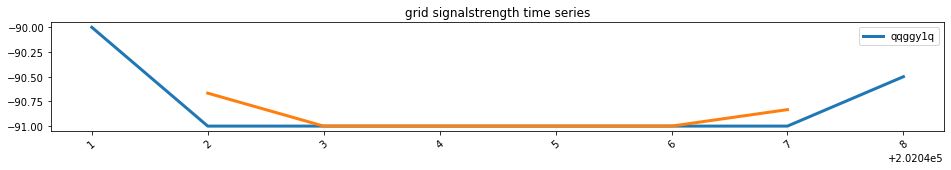

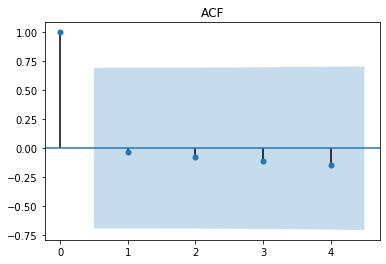

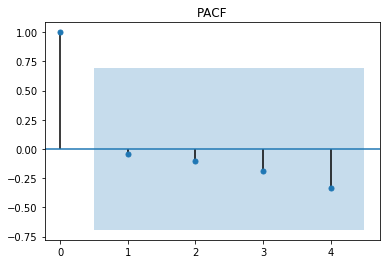

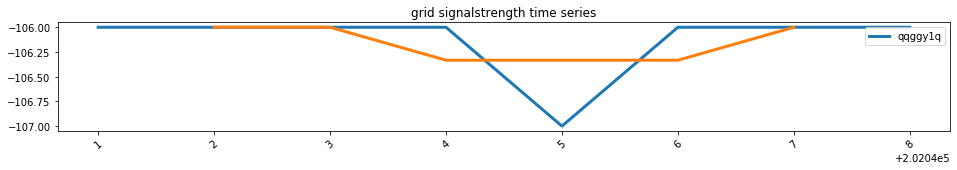

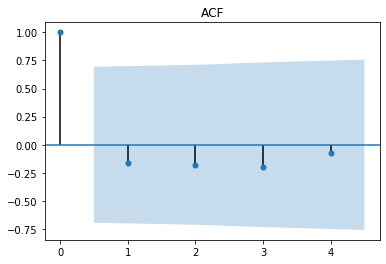

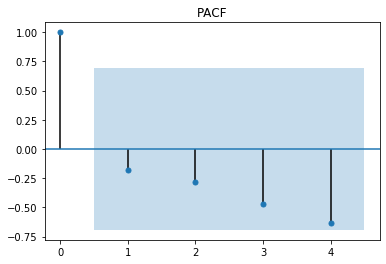

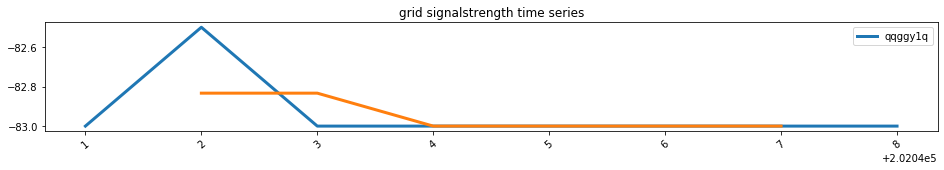

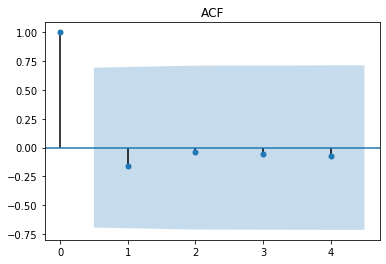

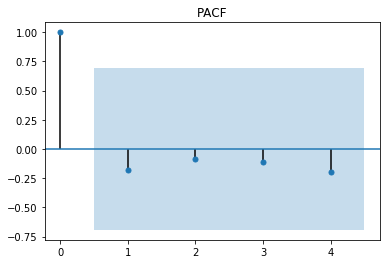

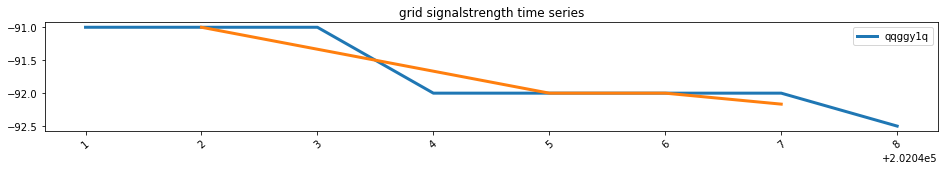

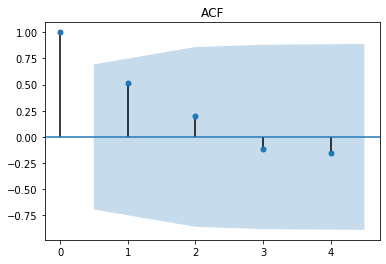

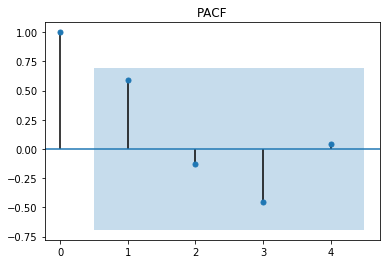

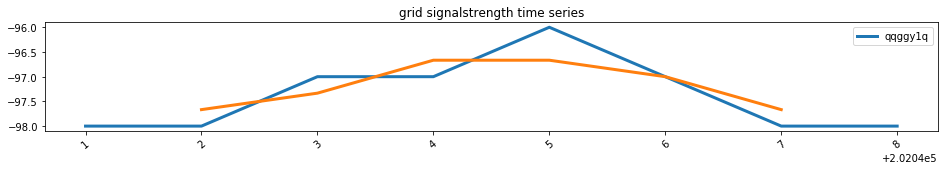

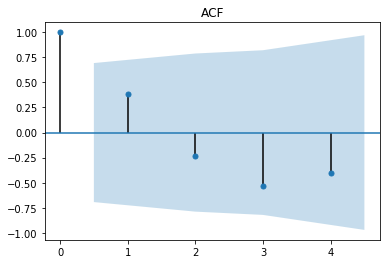

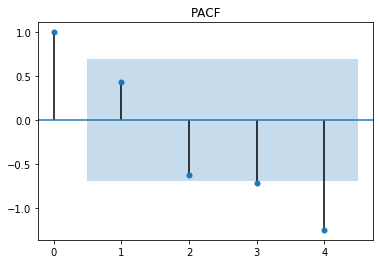

In [163]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def corr(ts):
    plot_acf(ts, lags=4,title="ACF")
    plot_pacf(ts,lags=4,title="PACF")
def plot_grid_kpi(df, kpi_col, *argv):
#     f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        f, ax=plt.subplots(figsize=(16,2))
        
        grid=df.loc[(df['geohash7']==a)].sort_values(['yearweek']).reset_index(drop=True)

        gridroll = grid.rolling(window=3,center=False).mean().dropna()
        ts= grid[['yearweek', kpi_col]]
        ts=ts.set_index('yearweek')
        ts.astype('int64')
        stationarity(ts)
        plt.plot(grid['yearweek'],grid[kpi_col],linewidth=3, label=a)
        plt.xticks(rotation=40)
        plt.legend(labels)
        plt.plot(gridroll['yearweek'],gridroll[kpi_col], linewidth=3 ,label='Rolling Mean')
        ax.set(title='grid ' + kpi_col + ' time series' )
        corr(ts)
plot_grid_kpi(df1, 'signalstrength', *grid_list[0:5])

   yearweek geohash7  signalstrength  signalstrength_watt
0    202041  qqggy1q           -90.0         1.000000e-09
1    202042  qqggy1q           -91.0         7.943282e-10
2    202043  qqggy1q           -91.0         7.943282e-10
3    202044  qqggy1q           -91.0         7.943282e-10
4    202045  qqggy1q           -91.0         7.943282e-10
5    202046  qqggy1q           -91.0         7.943282e-10
6    202047  qqggy1q           -91.0         7.943282e-10
7    202048  qqggy1q           -90.5         8.912509e-10
   signalstrength
0           -90.0
1           -91.0
2           -91.0
3           -91.0
4           -91.0
5           -91.0
6           -91.0
7           -90.5
   signalstrength
0           -90.0
1           -91.0
2           -91.0
3           -91.0
4           -91.0
5           -91.0    signalstrength
6           -91.0
7           -90.5


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 2, 0)
                             ARIMA Model Results                              
Dep. Variable:      D2.signalstrength   No. Observations:                    4
Model:                 ARIMA(0, 2, 0)   Log Likelihood                  -2.328
Method:                           css   S.D. of innovations              0.433
Date:                Wed, 16 Dec 2020   AIC                              8.656
Time:                        13:30:23   BIC                              7.428
Sample:                             2   HQIC                             5.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2500      0.217      1.155      0.248      -0.174       0.674

Mean absolute percentage error: 0.412847
   yearweek geohash7  signalstrength  signalstrength_watt
0    202041  qqggy1t 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: Ru

(4, 0, 0)


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                              ARMA Model Results                              
Dep. Variable:         signalstrength   No. Observations:                    6
Model:                     ARMA(4, 0)   Log Likelihood                   2.835
Method:                       css-mle   S.D. of innovations              0.029
Date:                Wed, 16 Dec 2020   AIC                              6.329
Time:                        13:30:25   BIC                              5.080
Sample:                             0   HQIC                             1.328
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -106.2174      0.026  -4110.621      0.000    -106.268    -106.167
ar.L1.signalstrength    -0.9936      0.040    -24.888      0.000      -1.072      -0.915
ar.L2.signal

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid va

(0, 0, 0)
                              ARMA Model Results                              
Dep. Variable:         signalstrength   No. Observations:                    6
Model:                     ARMA(0, 0)   Log Likelihood                   1.567
Method:                           css   S.D. of innovations              0.186
Date:                Wed, 16 Dec 2020   AIC                              0.865
Time:                        13:30:27   BIC                              0.449
Sample:                             0   HQIC                            -0.802
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -82.9167      0.076  -1089.968      0.000     -83.066     -82.768

Mean absolute percentage error: 0.100402
   yearweek geohash7  signalstrength  signalstrength_watt
0    202041  qqggy1y 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: Hess

(2, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:       D.signalstrength   No. Observations:                    5
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  24.238
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 16 Dec 2020   AIC                            -40.476
Time:                        13:30:27   BIC                            -42.039
Sample:                             1   HQIC                           -44.669
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.3333   1.15e-05  -2.91e+04      0.000      -0.333      -0.333
ar.L1.D.signalstrength    -1.0000   4.82e-05  -2.08e+04      0.000      -1.000      -

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning

(1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:       D.signalstrength   No. Observations:                    5
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -3.592
Method:                       css-mle   S.D. of innovations              0.427
Date:                Wed, 16 Dec 2020   AIC                             13.183
Time:                        13:30:29   BIC                             12.011
Sample:                             1   HQIC                            10.038
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3616      0.114      3.163      0.002       0.137       0.586
ar.L1.D.signalstrength    -0.8826      0.171     -5.152      0.000      -1.218      -

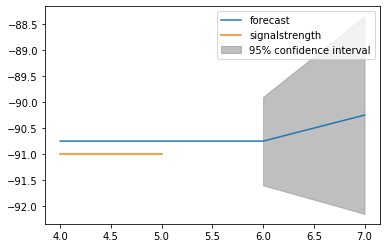

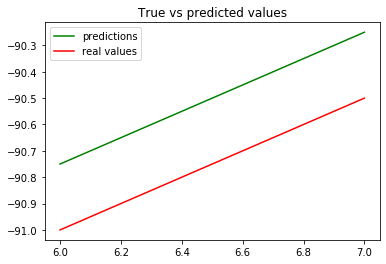

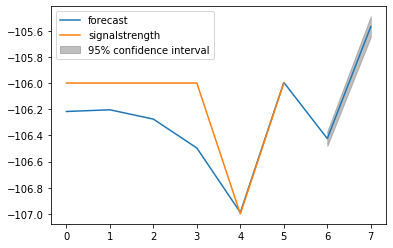

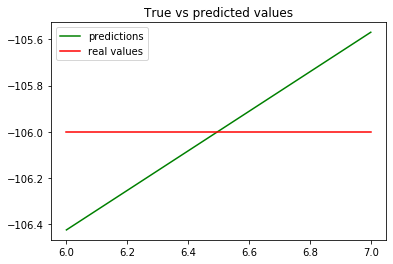

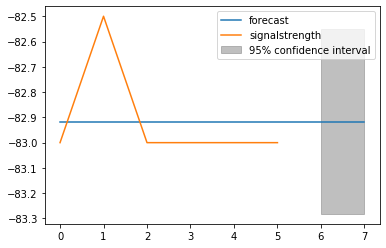

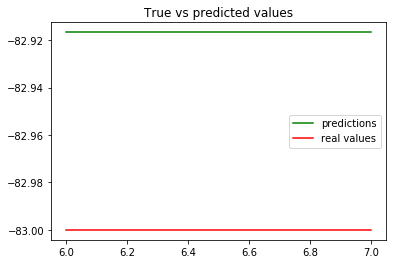

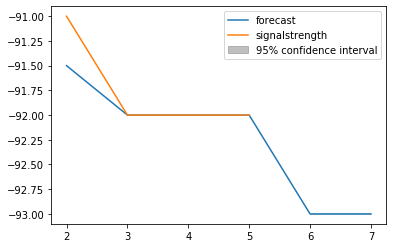

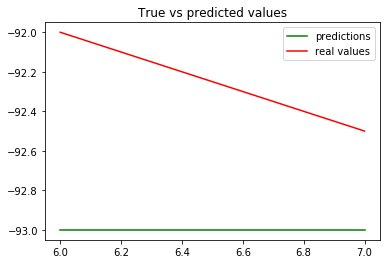

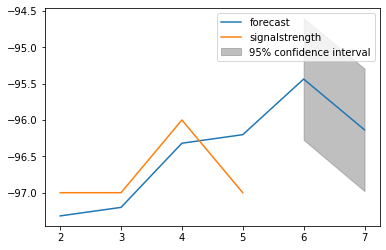

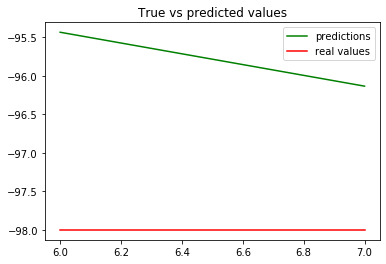

In [168]:
def grid_arima(df, kpi_col, *argv):
    labels=argv
    for a in argv: 
        grid=df.loc[(df['geohash7']==a)].sort_values(['yearweek']).reset_index(drop=True)
        print(grid)
        gridroll = grid.rolling(window=3,center=False).mean().dropna()
        ts= grid[[kpi_col]]
        
        print(ts)
        ts.astype('int64')
        train,test=split(ts)
        print(train,test)
        pred=arima(train,test)
grid_arima(df1, 'signalstrength', *grid_list[0:5])


In [76]:
import datetime
def get_week_tsel(date_int):
    date_str = (date_int - 480000)
    return int(datetime.datetime.strptime(str(date_str), '%Y%m%d').strftime('%Y%V')) + 4800
int(get_week_tsel(20171230))

201701

In [148]:
df1.index

RangeIndex(start=0, stop=226592, step=1)